<a name="1common."></a>
## Содержание:
* [1. Описание проекта, описание данных, загрузка и импорт библиотек](#1.)
* [2. Анализ продукта](#2.)
     - [2.1. DAU, WAU, MAU](#2.1.)
     - [2.2. Анализ сессий](#2.2.)
     - [2.3. User Retention](#2.3.)
* [3. Анализ продаж](#3.)
     - [3.1. Когда начинают покупать?](#3.1.)
     - [3.2. Cредний чек](#3.2.)
     - [3.3. LTV](#3.3.)
* [4. Анализ затрат на маркетинг](#4.)
     - [4.1. Расходы, CAC](#4.1.)
     - [4.2. ROMI](#4.2.)
* [5. Метрики по рекламным источникам](#5.)
* [6. Общий вывод и рекомендации](#5.)

 <a name="1."><a/><br/>
    <font size ="5"><b>1. Описание проекта, описание данных, загрузка и импорт библиотек</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

## Аналитика в сервисе продажи билетов

У нас в распоряжении есть данные с июня 2017 по конец мая 2018 года:   
* лог сервера с данными о посещениях сайта,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Мы изучили:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

In [1]:
import pandas as pd #работа с таблицами
import seaborn as sns #heatmap
from matplotlib import pyplot as plt #графики
import numpy as np #математика

In [2]:
visits = pd.read_csv('C:/Users/User/Desktop/Python/Практикум/df_visits.csv')
orders = pd.read_csv('C:/Users/User/Desktop/Python/Практикум/df_orders.csv')
costs = pd.read_csv('C:/Users/User/Desktop/Python/Практикум/df_costs.csv')

In [3]:
all_df = [visits, orders, costs]#описание таблиц

for df in all_df:
    name =[x for x in globals() if globals()[x] is df][0] # вытаскиваем наименование датафрейма
    print('Информация о датафрейме {}\n'.format(name))
    print( df.info() )
    print()
    print('Первые 5 строк {}'.format(name))
    print( df.head(5) )
    print()
    for i in df.columns:
        print('Число пропущенных значений в столбце ', i, ' = ', df[i].isnull().sum())
    print('Число дубликатов в датафрейме {}'.format(name), df.duplicated().sum())
    print('--------------------------------------------')

Информация о датафрейме visits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 6 columns):
Unnamed: 0    359400 non-null int64
Device        359400 non-null object
End Ts        359400 non-null object
Source Id     359400 non-null int64
Start Ts      359400 non-null object
Uid           359400 non-null uint64
dtypes: int64(2), object(3), uint64(1)
memory usage: 16.5+ MB
None

Первые 5 строк visits
   Unnamed: 0   Device               End Ts  Source Id             Start Ts  \
0           0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1           1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2           2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3           3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4           4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    1040603572448917

In [4]:
#все данные 'даты' записанны в формате 'str'. Мы изменили на формат 'datetime64[ns]', для удобства работы.
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

<a name="2."><a/><br/>
    <font size ="5"><b>2.Анализ продукта</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)
    <a name="2.1."><a/><br/>
    <font size ="4"><b>2.1.DAU, WAU, MAU</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [5]:
#вычленим в отдельные столбцы из даты дни, недели и месяца
visits['date'] = visits['Start Ts'].dt.date
visits['week'] = visits['Start Ts'].dt.week
visits['month'] = visits['Start Ts'].dt.month
visits.head()

,Unnamed: 0,Device,End Ts,Source Id,Start Ts,Uid,date,week,month
0,0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12
1,1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2
2,2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7
3,3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5
4,4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12


In [6]:
day = visits.groupby('date').agg({'Uid': 'nunique'})
print('Среднее число уникальных пользователей в день(DAU):', int(day['Uid'].mean()))
week = visits.groupby('week').agg({'Uid': 'nunique'})
print('Среднее число уникальных пользователей в неделю(WAU):', int(week['Uid'].mean()))
month = visits.groupby('month').agg({'Uid': 'nunique'})
print('Среднее число уникальных пользователей в месяц(MAU):', int(month['Uid'].mean()))

Среднее число уникальных пользователей в день(DAU): 907
Среднее число уникальных пользователей в неделю(WAU): 5825
Среднее число уникальных пользователей в месяц(MAU): 23228


<a name="2.2."><a/><br/>
    <font size ="4"><b>2.2.Анализ сессий</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [7]:
print('Всего число сессий:', visits['Start Ts'].count())
ses_day = visits.groupby('date').agg({'Start Ts': 'count'})
print('Среднее число сессий в день:', int(ses_day['Start Ts'].mean()))

Всего число сессий: 359400
Среднее число сессий в день: 987


Для нахождения длительности одной сессии было принято решение взять медиану, так как мода не отразит среднее значение.

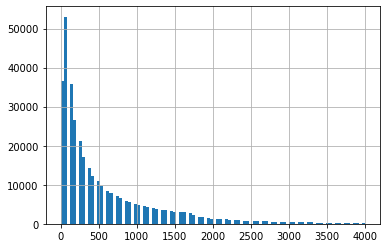

In [8]:
#найдем длительность сессии в секундах
visits['session_duration_sec'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds

#отобразим распределение 
visits['session_duration_sec'].hist(bins=100, range = (0,4000))

(0, 3000)

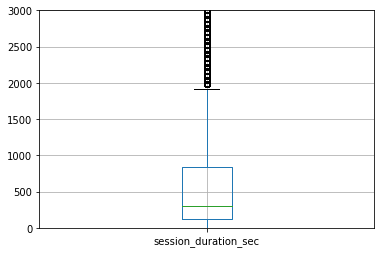

In [9]:
#посмотрим на выбросы
visits.boxplot('session_duration_sec')
plt.ylim(0, 3000)

In [10]:
#избавимся от выбросов
ff = visits[visits['session_duration_sec'] < 1800]

#переведем в минуты, для удобства восприятия
print('Одна сессия в среднем длится:', int(
    ff['session_duration_sec'].median() / 60), 'минут')

Одна сессия в среднем длится: 4 минут


<a name="2.3."><a/><br/>
    <font size ="4"><b>2.3.User Retention</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [11]:
#добавим в таблицу столбцы первого месяца захода на сайт, и месяц, где была активность
first_dates = visits.groupby('Uid')['Start Ts'].min()
first_dates.name = 'first_dates'
visits = visits.merge(
    first_dates, on='Uid')

In [12]:
#сменим типы на удобные нам
visits['first_ses_month'] = visits['first_dates'].astype('datetime64[M]')
visits['ses_month'] = visits['Start Ts'].astype('datetime64[M]')
visits.head()

,Unnamed: 0,Device,End Ts,Source Id,Start Ts,Uid,date,week,month,session_duration_sec,first_dates,first_ses_month,ses_month
0,0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,114820,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01


Теперь посмотрим, как часто люди возвращаются к нам. Когорта - месяц, действие - заход на сайт. Построим heatmap и взглянем на возвраты в абсолютном выражении

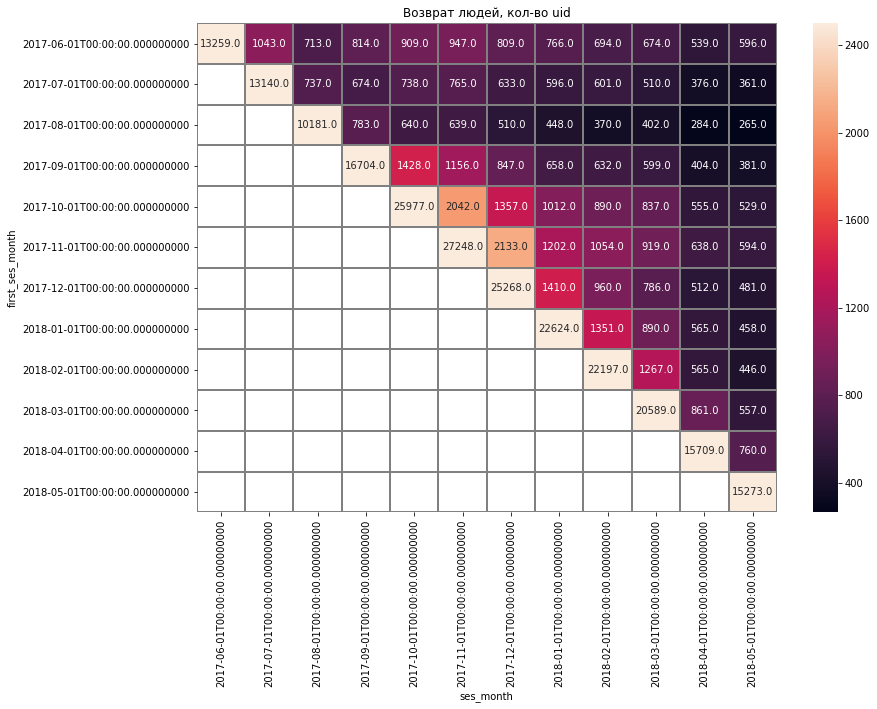

In [13]:
life = visits.pivot_table(index='first_ses_month',
    columns='ses_month',
    values='Uid',
    aggfunc='nunique')
plt.figure(figsize=(13, 9))
plt.title('Возврат людей, кол-во uid')
sns.heatmap(life, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmax=2500)

Не очень пользователи любят возвращатся к нам, взглянем на эту картину в относительном выражении, добавив срок жизни одной кагорты шагом в месяц

In [14]:
#найдем месяц жизни и его порядковый номер
visits['cohort_lifetime'] = visits['ses_month'] - visits['first_ses_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)
cohorts = visits.groupby(['first_ses_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()
cohorts.head()

,first_ses_month,cohort_lifetime,Uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Для подсчета относительного коэффициента возврата нам подойдет Retention Rate, который покажет какой процент людей остается с нами в течении времени

In [15]:
#найдем все пользователей которые зашли вперые
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_ses_month','Uid']]

#отсортируем по убыванию даты захода
inital_users_count = inital_users_count.sort_values(by = 'first_ses_month')
inital_users_count = inital_users_count.rename(columns={'Uid':'cohort_users'})

#объединим с информацией о времени жизни когорты
cohorts = cohorts.merge(inital_users_count,on='first_ses_month')

#добавим Retention
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']
cohorts.head()

,first_ses_month,cohort_lifetime,Uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


Постром heatmap для наглядного отображение retantion rate

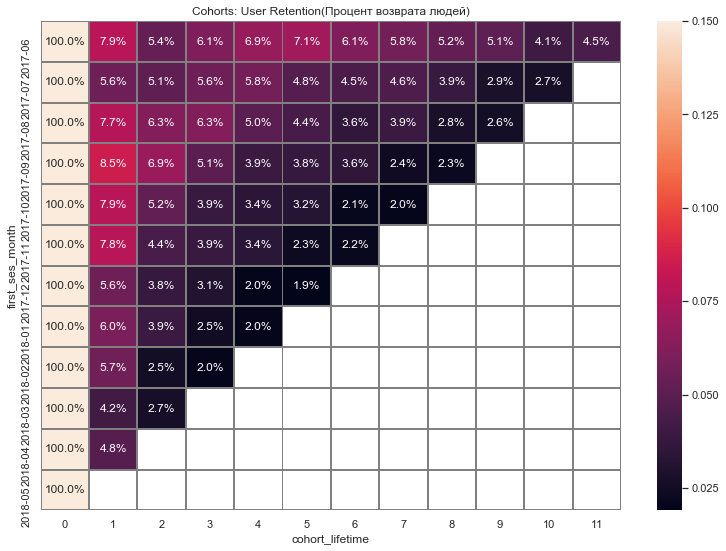

In [16]:
cohorts['first_ses_month'] = cohorts['first_ses_month'].dt.strftime('%Y-%m')
retention_pivot = cohorts.pivot_table(index='first_ses_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention(Процент возврата людей)')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',vmax=0.15)

In [17]:
rr = cohorts[(cohorts['first_ses_month'] == '2017-06') & (cohorts['cohort_lifetime'] > 0)]
print('Средний Retention Rate за 1 месяц: {:.1%}'.format(rr['retention'].mean()))

Средний Retention Rate за 1 месяц: 5.8%


### Вывод

У нас очень низкий коэффициент удержания. Возможно проблема в сервисе или в привлечении нами нецелевой аудитории. Будем разбираться

<a name="3."><a/><br/>
    <font size ="5"><b>3.Анализ продаж</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)
    <a name="3.1."><a/><br/>
    <font size ="4"><b>3.1.Когда начинают покупать?</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [18]:
#найдем первый месяц покупки
first_buy = orders.groupby('Uid')['Buy Ts'].min()
first_buy.name = 'first_buy'

#добавим в нашу таблицу
orders = orders.merge(first_buy, on='Uid')
orders.head()

,Unnamed: 0,Buy Ts,Revenue,Uid,first_buy
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [19]:
#переведем все в нужные нам форматы
orders['first_order_month'] = orders['first_buy'].astype('datetime64[M]')
orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')#переведем все в нужные нам форматы
orders.head()

,Unnamed: 0,Buy Ts,Revenue,Uid,first_buy,first_order_month,order_month
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [20]:
#добавим время певого входа на сайт
orders = orders.merge(first_dates, on='Uid')

Расчитаем среднее время которое проходит с момента входа, до моента покупки. Для удобства переведем в минуты

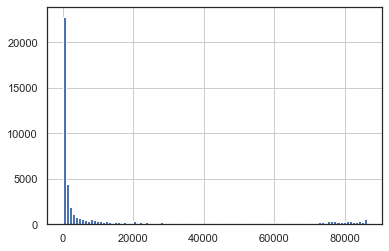

In [21]:
#нужный тип
orders['first_buy'] = pd.to_datetime(orders['first_buy'])

#посчитам время в секундах между входом и покупкой
orders['time_to_buy'] = (
    orders['first_buy'] - orders['first_dates']).dt.seconds

#взглянем на распределение
orders['time_to_buy'].hist(bins = 100)

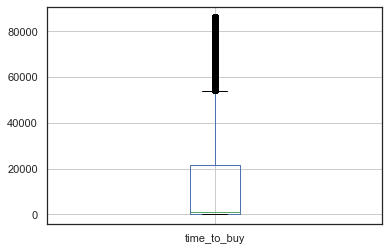

In [22]:
#посмотрим выбросы
orders.boxplot('time_to_buy')

In [23]:
#избавимся от выбросов
gg = orders[orders['time_to_buy'] < 50000]
print('Среднее время до покупки:', int(gg['time_to_buy'].median() / 60) , 'минут')
gg = gg.merge(visits[['Start Ts', 'End Ts', 'Uid']], on= 'Uid')

Среднее время до покупки: 11 минут


In [24]:
#посчитаем сколько нужно сессий, чтобы совершить покупку
gg1 = gg[['Buy Ts', 'Uid', 'Start Ts', 'End Ts']]
gg1 = gg1.groupby('Uid').agg({'Start Ts' : 'nunique', 'Buy Ts' : 'nunique'}).reset_index()
print('В среднем пользователю нужно {:.1f} заходов, чтобы совершить {:.1f} покупок'.format(gg1['Start Ts'].mean(), gg1['Buy Ts'].mean()))

В среднем пользователю нужно 2.3 заходов, чтобы совершить 1.3 покупок


Создадим метрику, назовем ее SAB(session and buy), которая покажет нам отношение количество покупок к количеству заказов. Если SAB < 1 то заходов больше, чем покупок. Если SAB = 1 то эти показатели равны.

In [25]:
gg1['metrica'] = gg1['Buy Ts'] / gg1['Start Ts'] 
print('SAB = {:.2f}'.format(gg1['metrica'].mean()))

SAB = 0.81


### Вывод

Люди довольно долго изучают наш продукт, прежде чем купить. Возможно связанно с широким ассортиментов 'афиш'

Но в среднем мы движемся к тому, чтобы каждая сессия завершалась продажей, люди заходят к нам с определенной целью, совершить покупку

**Сколько раз покупают за период?**

In [26]:
#периодом возьмем месяц
count_purchase = orders.groupby(['order_month']).agg({'Revenue':'count'})
print('Среднее количеcтво покупок за месяц:', int(count_purchase['Revenue'].mean()))

Среднее количеcтво покупок за месяц: 3878


In [27]:
gg_mean = gg.groupby('Uid').agg({'Buy Ts' : 'nunique'})
print('Среднее количество покупок на 1 покупателя:{:.1f}'.format(gg_mean['Buy Ts'].median()))

Среднее количество покупок на 1 покупателя:1.0


### Вывод

Покупок в месяц много, но это все новые клиенты. Клиенты в среднем совершают только 1 покупку. Это логично, Retention то низкий. Отдел маркетинга хорошо привлекает клиентов, но плохо удерживает.

<a name="3.2."><a/><br/>
    <font size ="4"><b>3.2.Cредний чек</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Проведем когортный анализ изменения среднего чека за период в 12 месяцев. Когорта - месяц, действия - средняя покупка одного клиента

In [28]:
#сгруппироуем по месяцам
orders_cohorts = orders.groupby(
    ['first_order_month','order_month']).agg({'Revenue':'sum','Uid':'nunique'})

#найдем выручку с одного клиента
orders_cohorts['revenue_per_user'] = orders_cohorts['Revenue'] / orders_cohorts['Uid']
orders_cohorts.head()

Revenue   Uid  revenue_per_user
first_order_month order_month                                 
2017-06-01        2017-06-01   9557.49  2023          4.724414
                  2017-07-01    981.82    61         16.095410
                  2017-08-01    885.34    50         17.706800
                  2017-09-01   1931.30    54         35.764815
                  2017-10-01   2068.58    88         23.506591

In [29]:
#добавим срок жизни когорты
orders_cohorts = orders_cohorts.reset_index()
orders_cohorts['cohort_lifetime'] = orders_cohorts['order_month'] - orders_cohorts['first_order_month']
orders_cohorts['cohort_lifetime'] = orders_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')

#приведем к нужным типам
orders_cohorts['cohort_lifetime'] = orders_cohorts['cohort_lifetime'].round().astype('int')
orders_cohorts['first_order_month'] = orders_cohorts['first_order_month'].dt.strftime('%Y-%m')

Взглянем на изменение среднего чека с помощью heatmap в абсолютных показателях.

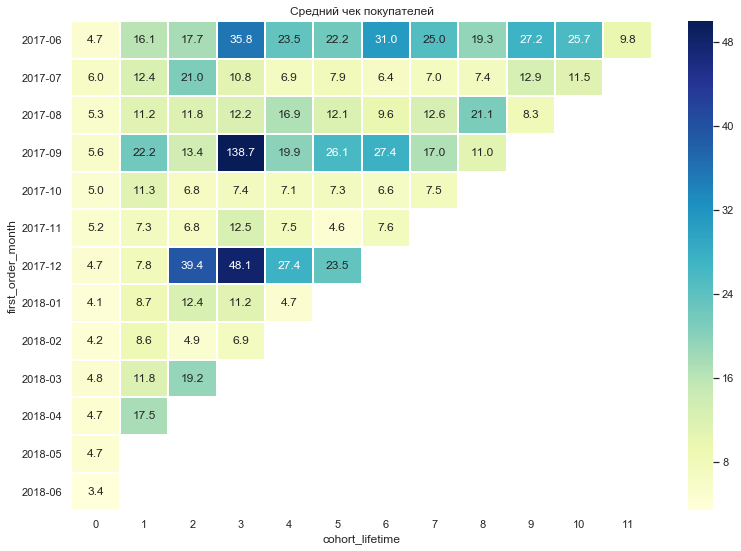

In [30]:
orders_cohorts['revenue_per_user'] = orders_cohorts['revenue_per_user'].round(2)
revenue_per_user_pivot = orders_cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_per_user',
    aggfunc='sum')
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='white',cmap='YlGnBu', vmax=50)

Text(0.5, 1.0, 'Средний чек в месяц')

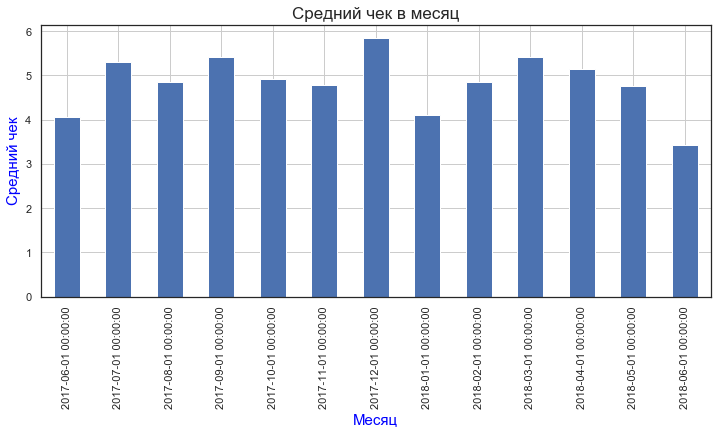

In [31]:
#найдем выручку за каждый месяц и количество покупок nunique
mean_revenue = orders.groupby(
    'order_month').agg({'Revenue':'sum','Buy Ts':'count'})

#посчитаем средний чек в когорт, выручку за все время существования клиентов поделим на количество клиентов
mean_revenue['one_purchase'] = mean_revenue['Revenue'] / mean_revenue['Buy Ts']

#количество выручки в месяц я делю на количество чеков
mean_revenue['one_purchase'].plot.bar(grid=True, figsize=(12, 5))
plt.xlabel('Месяц', fontsize=15, color='blue')
plt.ylabel('Средний чек', fontsize=15, color='blue')
plt.title('Средний чек в месяц', fontsize=17)

In [32]:
print('Средний чек:{:.2f}'.format(mean_revenue['one_purchase'].mean()))

Средний чек:4.84


### Вывод

Наблюдается тендеция роста среднего чека с увеличением срока жизни когорты. Люди которые остаются с нами начинают нам доверять и платить больше. Нужно подумать о увеличении Retention Rate

Средний чек больше все у 1 и 4 когорты, нужно проверить как мы привлекали клиентов в этот месяц

<a name="3.3."><a/><br/>
    <font size ="4"><b>3.3.LTV</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Проведем когортный анализ показателя средней валовой прибыли на одного клиента за весь его срок пользования нашим сервисом

In [33]:
#сгруппируем по пользователям, найем первый месяц заказа и сумму выручки
first_orders = orders.groupby('Uid').agg({'order_month': 'min', 'Revenue' : 'sum'}).reset_index()
first_orders.columns = ['uid', 'first_order_month', 'revenue']

#найдем количество новых покупателей каждый месяц
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [34]:
#найдем сумму по выручке за каждый месяц
cohorts_for_ltv = orders.groupby(['first_order_month','order_month']).agg({'Revenue': 'sum'}).reset_index()

#объединим все таблциы в одну
report = pd.merge(cohort_sizes, cohorts_for_ltv, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,Revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [35]:
#маржинальность возьмем на уровне 30%
margin_rate = 0.3

#Посчитаем валовую прибыль и возраст наших когорт
report['val_prof'] = report['Revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

# найдем ltv на каждого клиента
report['ltv'] = report['val_prof'] / report['n_buyers']# найдем ltv на каждого клиента
report.head()

,first_order_month,n_buyers,order_month,Revenue,val_prof,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,2867.247,0,1.417324
1,2017-06-01,2023,2017-07-01,981.82,294.546,1,0.145599
2,2017-06-01,2023,2017-08-01,885.34,265.602,2,0.131291
3,2017-06-01,2023,2017-09-01,1931.30,579.390,3,0.286401
4,2017-06-01,2023,2017-10-01,2068.58,620.574,4,0.306759


In [36]:
#выведем таблицей, как изменяется ltv с течением времени
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.417,0.146,0.131,0.286,0.307,0.221,0.285,0.174,0.166,0.182,0.171,0.077
2017-07-01,1.803,0.101,0.187,0.108,0.053,0.047,0.036,0.043,0.048,0.044,0.047,
2017-08-01,1.583,0.142,0.138,0.117,0.148,0.085,0.063,0.122,0.088,0.056,,
2017-09-01,1.693,0.335,0.156,1.193,0.12,0.194,0.21,0.073,0.055,,,
2017-10-01,1.501,0.161,0.057,0.047,0.045,0.036,0.025,0.035,,,,
2017-11-01,1.546,0.12,0.06,0.097,0.044,0.016,0.034,,,,,
2017-12-01,1.421,0.078,0.278,0.32,0.094,0.101,,,,,,
2018-01-01,1.241,0.088,0.091,0.043,0.019,,,,,,,
2018-02-01,1.247,0.083,0.024,0.022,,,,,,,,


In [37]:
#найдем выручку за все время существования клиента
ltv_per_user = orders.groupby(
    'first_order_month').agg({'Revenue':'sum','Uid':'nunique'})

Text(0.5, 1.0, 'LTV одного клиента в зависимости от периода пользования')

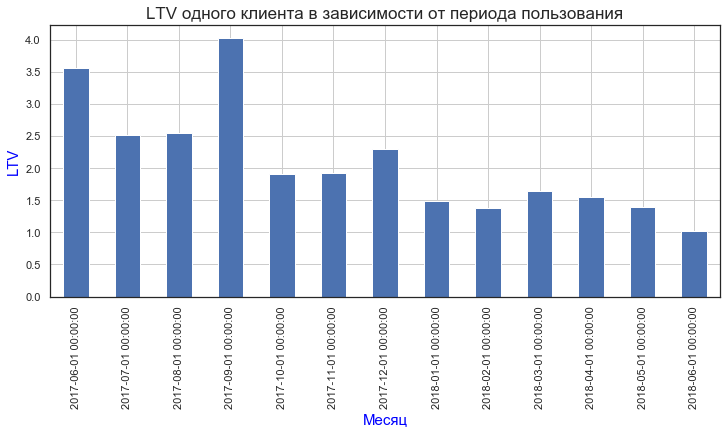

In [38]:
#найдем общий ltv на пользователя в зависимости от когорты
ltv_per_user['per_user'] = (ltv_per_user['Revenue']*margin_rate) / ltv_per_user['Uid']
ltv_per_user['per_user'].plot.bar(grid=True, figsize=(12, 5))
plt.xlabel('Месяц', fontsize=15, color='blue')
plt.ylabel('LTV', fontsize=15, color='blue')
plt.title('LTV одного клиента в зависимости от периода пользования', fontsize=17)

In [39]:
#Приведем к нужному типу
report['first_order_month'] = pd.to_datetime(report['first_order_month'])

costs['dt'] = pd.to_datetime(costs['dt'])
costs['dt'] = costs['dt'].dt.strftime('%Y-%m')

#Сделаем срез по первой кагорте и найдем сумму расходов по привлечению
revenue_20170601 = report[report['first_order_month'] == '2017-06-01']
costs_20170601 = costs[costs['dt'] == '2017-06']['costs'].sum()

#Найдем новых пользователей и расчитаем нужныем нам показатели. Выведем на экран показатели первой кагорты
n_buyers_20170601 = revenue_20170601['n_buyers'][0]
cac_20170601 = costs_20170601 / n_buyers_20170601
ltv_20170601   = output.loc['2017-06-01'].sum()
print('CAC первой кагорты =', cac_20170601.round(2))
print('LTV первой кагорты (за 12 месяцев) =', ltv_20170601.round(2))

CAC первой кагорты = 8.91
LTV первой кагорты (за 12 месяцев) = 3.56


### Вывод

LTV падаем с каждым месяцом. Это связано с низким коэффициентом удержания наших клиентов

<a name="4."><a/><br/>
    <font size ="5"><b>4.Анализ затрат на маркетинг</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)
    <a name="4.1."><a/><br/>
    <font size ="4"><b>4.1.Расходы, CAC</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

**Посчитам CAC - расходы маркетинга на одного клиента. Данный показатель поможет дальше расчитать нам ROMI - коэффицент возврата инвестиций в маркетинг**

In [40]:
#найдем расходы на каждый месяц
monthly_costs = costs.groupby('dt')['costs'].sum()
monthly_costs

dt
2017-06    18015.00
2017-07    18240.59
2017-08    14790.54
2017-09    24368.91
2017-10    36322.88
2017-11    37907.88
2017-12    38315.35
2018-01    33518.52
2018-02    32723.03
2018-03    30415.27
2018-04    22289.38
2018-05    22224.27
Name: costs, dtype: float64

In [41]:
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m')

#объединим с таблицей прибыли
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='dt')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,Revenue,val_prof,age,ltv,costs,cac
0,2017-06,2023,2017-06-01,9557.49,2867.247,0,1.417324,18015.0,8.905091
1,2017-06,2023,2017-07-01,981.82,294.546,1,0.145599,18015.0,8.905091
2,2017-06,2023,2017-08-01,885.34,265.602,2,0.131291,18015.0,8.905091
3,2017-06,2023,2017-09-01,1931.30,579.390,3,0.286401,18015.0,8.905091
4,2017-06,2023,2017-10-01,2068.58,620.574,4,0.306759,18015.0,8.905091


In [42]:
cac_mean = report_new.groupby('first_order_month')['cac'].mean().mean()
print('Средний расход на привлечение 1 клиента:{:.2f}'.format(cac_mean))

Средний расход на привлечение 1 клиента:9.15


In [43]:
print('Всего сумма расходов на маркетинг за год:', int(costs['costs'].sum()))

Всего сумма расходов на маркетинг за год: 329131


In [44]:
#затраты на каждый источник
costs.groupby('source_id').agg({'costs':'sum'}).sort_values(by = 'costs')

,costs
source_id,
9,5517.49
10,5822.49
1,20833.27
2,42806.04
5,51757.10
4,61073.60
3,141321.63


Средние расходы на маркетинг в месяц: 27427


Text(0.5, 1.0, 'Расходы на маркетинг')

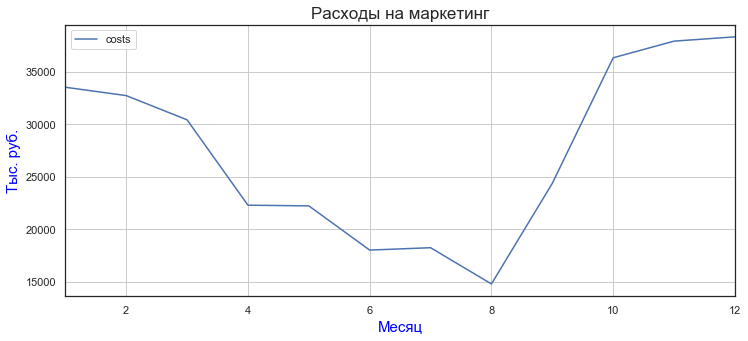

In [45]:
#вернем в нужным нам вид и вычленим месяц
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] =costs['dt'].dt.month

#найдем средние расходы в месяц
month_costs = costs.groupby('month').agg({'costs':'sum'})
print('Средние расходы на маркетинг в месяц:', int(month_costs['costs'].mean()))

#посмотрим на расходы каждый месяц
month_costs.plot(grid=True, figsize=(12, 5))
plt.xlabel('Месяц', fontsize=15, color='blue')
plt.ylabel('Тыс. руб.', fontsize=15, color='blue')
plt.title('Расходы на маркетинг', fontsize=17)

### Вывод

Больше всего расходы на 3,4,5 источник. Самые маленькие 9,10. Наблюдаем снижение расходов на меркетинг к новому году и потом снова резкое увеличение(январские заморозки?)

<a name="4.2."><a/><br/>
    <font size ="4"><b>4.2.ROMI</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [46]:
#найдем коэффициент окупаемости наших расходов в меркетинг
report_new['romi'] =  report_new['ltv'] / report_new['cac']

#посмотрим на него в разрезе когорт
output_romi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output_romi.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.16,0.18,0.19,0.22,0.26,0.28,0.31,0.33,0.35,0.37,0.39,0.4
2017-07,0.19,0.2,0.22,0.23,0.24,0.24,0.25,0.25,0.26,0.26,0.27,
2017-08,0.15,0.16,0.17,0.18,0.2,0.2,0.21,0.22,0.23,0.24,,
2017-09,0.18,0.21,0.23,0.36,0.37,0.39,0.41,0.42,0.43,,,
2017-10,0.18,0.2,0.21,0.21,0.22,0.22,0.22,0.23,,,,
2017-11,0.17,0.18,0.19,0.2,0.2,0.2,0.21,,,,,
2017-12,0.16,0.17,0.2,0.24,0.25,0.26,,,,,,
2018-01,0.12,0.13,0.14,0.15,0.15,,,,,,,
2018-02,0.14,0.15,0.15,0.15,,,,,,,,


In [47]:
print('ROMI первой когорты (1 год) =', (ltv_20170601 / cac_20170601).round(2))

ROMI первой когорты (1 год) = 0.4


Text(0.5, 1.0, 'Коэффициент окупаемости')

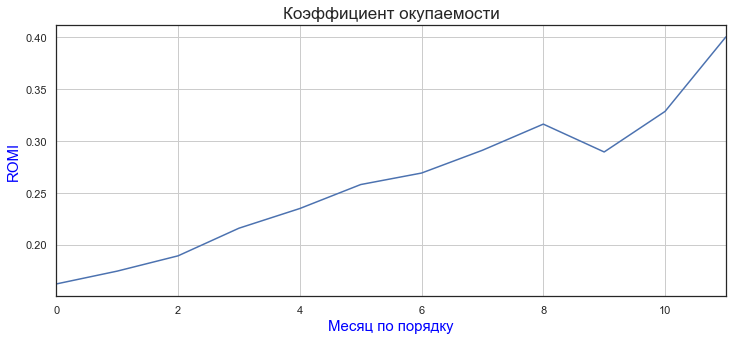

In [48]:
output_romi.cumsum(axis=1).mean(axis=0).plot(grid=True, figsize=(12, 5))
plt.xlabel('Месяц по порядку', fontsize=15, color='blue')
plt.ylabel('ROMI', fontsize=15, color='blue')
plt.title('Коэффициент окупаемости', fontsize=17)

### Вывод

Наши инвестиции не окупаются. Даже за год получается вернуть только 40% от них

<a name="5."><a/><br/>
    <font size ="5"><b>5.Метрики по рекламным источникам</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

**Отследить метрики по устройствам не получается, потому что нет информации о расходах на каждое устройство. По рекламным источникам у нас информация, что у одного клиента может быть 5 источников. Для более реальных результатов и правильной выручки, выберем первый источник привлечения, как основной**

Для этого мы сгруппируем и объединим в одну все таблицу по интересующим нас показателям

In [49]:
#соберем визиты и заказы по Uid
visits['date'] = pd.to_datetime(visits['date'])
orders = orders.merge(visits[['Uid', 'Source Id']], on = 'Uid')
orders.head()

,Unnamed: 0,Buy Ts,Revenue,Uid,first_buy,first_order_month,order_month,first_dates,time_to_buy,Source Id
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01 00:09:00,60,1
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01 00:14:00,660,2
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01 00:25:00,120,2
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01 00:14:00,900,2
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01 07:31:00,1620,3


In [50]:
#уберем повторяющиеся источники, для получения реального revenue
orders = orders.drop_duplicates()
orders['Buy Ts'] = orders['Buy Ts'].drop_duplicates()
orders = orders.fillna(0)
orders_new = orders[orders['Buy Ts'] != 0]

In [51]:
#сгруппируем по пользователям, найем первый месяц заказа и сумму выручки
first_orders3 = orders_new.groupby(['Uid', 'Source Id']).agg(
                        {'order_month': 'min', 'Revenue' : 'sum'}).reset_index()
first_orders3.columns = ['uid', 'source_id', 'first_order_month', 'revenue']
cohort_sizes3 = first_orders3.groupby(['first_order_month', 'source_id']).agg(
                                            {'uid': 'nunique', 'revenue' : 'sum'}).reset_index()
cohort_sizes3.columns = ['dt', 'source_id', 'n_buyers', 'revenue']

#вернем в нужный нам вид даты
costs['dt'] = pd.to_datetime(costs['dt'])

#сгруппируем по расходам
cs = costs.groupby(['dt', 'source_id']).agg({'costs' : 'sum'})
cs = cohort_sizes3.merge(cs, on = ['dt', 'source_id'])

#найдем нужные нам метрики
cs['ltv'] = cs['revenue']*margin_rate / cs['n_buyers']
cs['cac'] = cs['costs'] / cs['n_buyers']
cs['romi'] = cs['ltv'] / cs['cac']
cs.head()

,dt,source_id,n_buyers,revenue,costs,ltv,cac,romi
0,2017-06-01,1,192,6937.92,1125.61,10.840500,5.862552,1.849109
1,2017-06-01,2,258,6233.69,2427.38,7.248477,9.408450,0.770422
2,2017-06-01,3,543,2936.22,7731.65,1.622221,14.238766,0.113930
3,2017-06-01,4,404,2833.09,3514.80,2.103780,8.700000,0.241814
4,2017-06-01,5,355,3974.84,2616.12,3.359020,7.369352,0.455809


Text(0.5, 1.0, 'ROMI на одного покупателя')

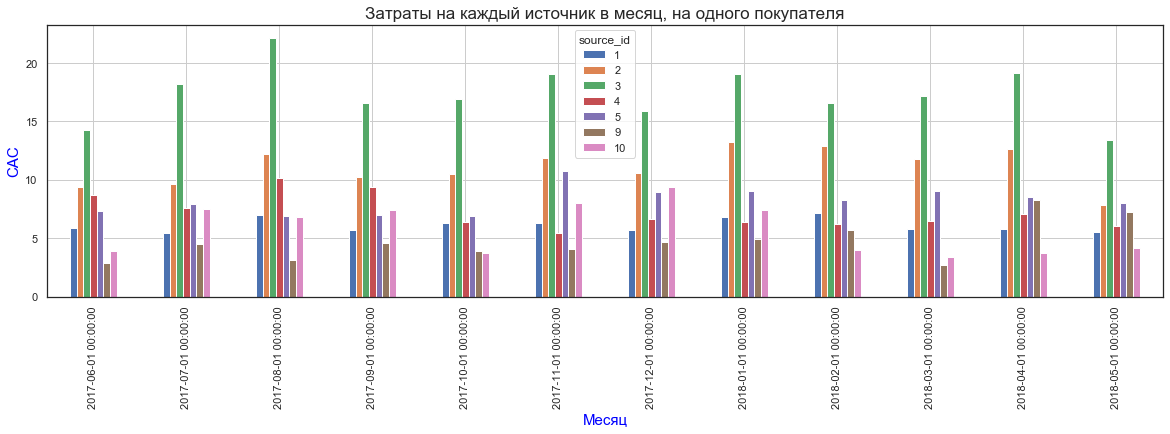

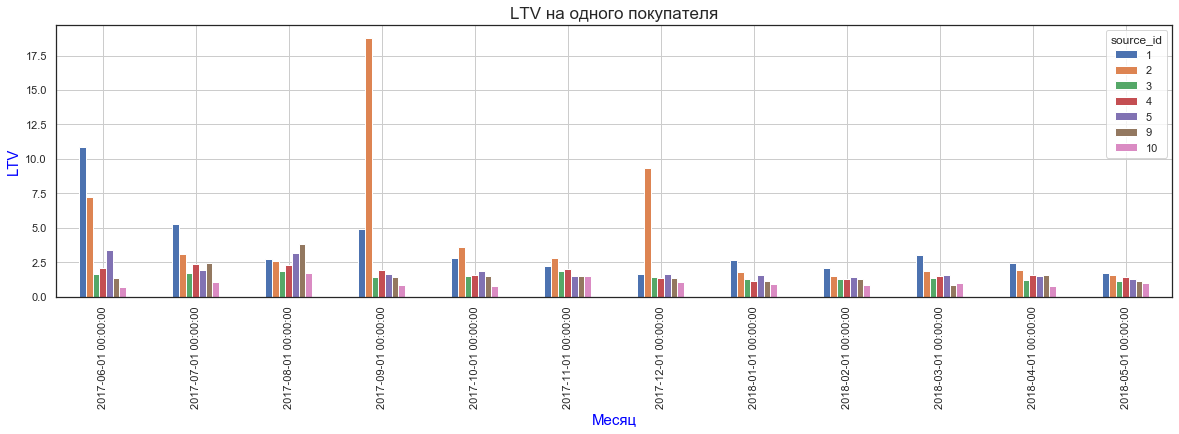

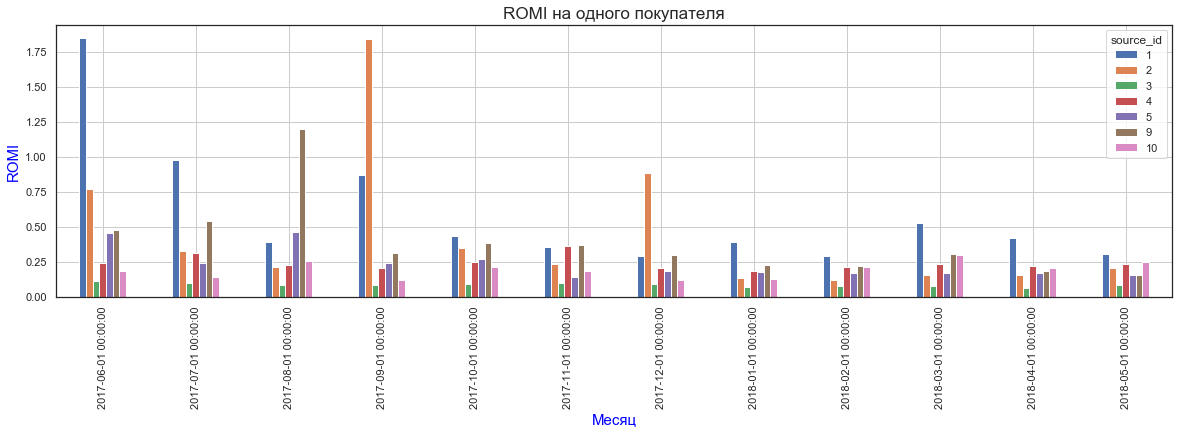

In [52]:
cs.pivot_table(
    index='dt',
    columns='source_id',
    values='cac',
    aggfunc='mean').plot.bar(grid=True, figsize=(20, 5))
plt.xlabel('Месяц', fontsize=15, color='blue')
plt.ylabel('CAC', fontsize=15, color='blue')
plt.title('Затраты на каждый источник в месяц, на одного покупателя', fontsize=17)

cs.pivot_table(
    index='dt',
    columns='source_id',
    values='ltv',
    aggfunc='mean').plot.bar(grid=True, figsize=(20, 5))
plt.xlabel('Месяц', fontsize=15, color='blue')
plt.ylabel('LTV', fontsize=15, color='blue')
plt.title('LTV на одного покупателя', fontsize=17)

cs.pivot_table(
    index='dt',
    columns='source_id',
    values='romi',
    aggfunc='mean').plot.bar(grid=True, figsize=(20, 5))
plt.xlabel('Месяц', fontsize=15, color='blue')
plt.ylabel('ROMI', fontsize=15, color='blue')
plt.title('ROMI на одного покупателя', fontsize=17)

### Вывод

Самые дорогие клиенты приходят с 3,2,4 источника, тогда как эти источники имеют очень низкий LTV и ROMI. Все наши клиенты в 1 и 2 источнике. Они относительно дешевы, приносят хорошую прибыль и окупаются быстрее всех. 

**По времени самый прибыльные клиенты(низкий CAC, высокие LTV и ROMI)**
1. 1 и 2 источники Июнь 2017
2. 2 и 9 источник Сентябрь 2017
3. 2 источник Декабрь 2017

Все остальные месяца, показали себя плохо. Рекламный бюджет не оправдан

<a name="6."><a/><br/>
    <font size ="5"><b>6.Общий вывод и рекомендации</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

# Общий вывод

Показатель | Значение 
---------------------------------- | -------------
Средний чек в месяц, в течении года                        | 5.59 
Retention Rate                     | 5.8%
            LTV, за год    | 3.56
          CAC, на одного покупателя| 9.15
            ROMI, за год   | 0.4

            
Проведя анализ и расчитав юнит экономику, мы можем сделать выводы:
1. Средний чек растет с лояльностью клиента, чем дольше он с нами, тем больше доверия и выше средний чек
2. Retention Rate падает с каждым месяцем и в среднем находится на очень низком уровне
3. LTV показывает хорошие показатели в первый месяц, но неуклонно падает в связи с низким коэфициентом удержания. LTV низкий, нужно думать над увеличением валовой прибыли
4. CAC на одного клиента находится на высоком по отношению к LTV. Превышает в несколько раз.
5. ROMI показывает неэффективность нашей маркетинговой стратегии в области привлечения новых клиентов и сохранения старых.

Рекомендации: **Мы привлекаем клиентов за очень дорого, зарабатываем с них мало. Нужны новые рекламные источники или способы привлечения клиентов.**

Рекомендации: **Нужны более эффективные методы удержания клиета, пересмотреть маркетинговую политику в области удержания клиента. Внедрить систему лояльности или улучшить информирование об акциях и скидках.**

Самые дорогие клиенты приходят с 3,4,5 источника, тогда как эти источники имеют очень низкий LTV и ROMI. Все наши клиенты в 1, 2  и 9 источнике. Они относительно дешевы, приносят хорошую прибыль и окупаются быстрее всех. **Перераспределить рекламный бюджет в 1, 2  и 9 источники**